<a href="https://colab.research.google.com/github/abhishekpal7630/4th-Year-Project/blob/main/SIP_report_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, spearmanr
import statsmodels.api as sm

In [ ]:
file_path = '/content/responses.xlsx'
df = pd.read_excel(file_path)
df = df.dropna(how='any')
df = df.reset_index()
drop_substring = 'factors significantly impacted'
cols_to_drop = [col for col in df.columns if drop_substring in col]
df = df.drop(columns=cols_to_drop)

substr_to_short = {
    'Client Type': 'client_type',
    'Investment Experience': 'investment_experience',
    'awareness of unlisted and Pre-IPO': 'preipo_awareness',
    'first hear about our investment opportunities': 'lead_source',
    'calls or follow-up conversations': 'num_calls',
    'quality and clarity of the information': 'info_quality',
    'follow-up communications': 'followup_helpful',
    'scale of 1 (lowest) to 5 (highest)': 'interest_level',
    'clear and compelling did you find our discussion on pricing': 'pricing_clarity',
    'satisfied are you with our engagement process': 'satisfaction',
    'decided to invest': 'conversion'
}
rename_map = {}
for col in df.columns:
    for substr, short in substr_to_short.items():
        if substr in col:
            rename_map[col] = short
            break

df = df.rename(columns=rename_map)
df.head()

,index,Timestamp,client_type,investment_experience,preipo_awareness,lead_source,num_calls,info_quality,followup_helpful,interest_level,pricing_clarity,satisfaction,conversion
0,0,2025-04-27 09:38:00.126,High Net Worth Individual(HNI),3-5 year,Medium,"Digital Marketing (email, social media)",2-3,Good,Yes,4.0,Somewhat Clear,Satisfied,Yes
1,1,2025-05-04 20:57:55.238,Retail Investor,less than 1 year,Low,Referral,1,Good,Somewhat,1.0,Somewhat Clear,Very Satisfied,No
2,2,2025-05-04 21:09:29.044,Retail Investor,less than 1 year,Medium,"Digital Marketing (email, social media)",1,Good,Yes,4.0,Somewhat Clear,Satisfied,Yes
3,4,2025-05-04 21:13:45.486,Retail Investor,less than 1 year,Low,Referral,1,Poor,No,1.0,Not Clear,Very Unsatisfied,No
4,5,2025-05-04 21:27:17.631,Institutional Investor,less than 1 year,Low,Financial Advisor,1,Fair,No,3.0,Somewhat Clear,Neutral,No


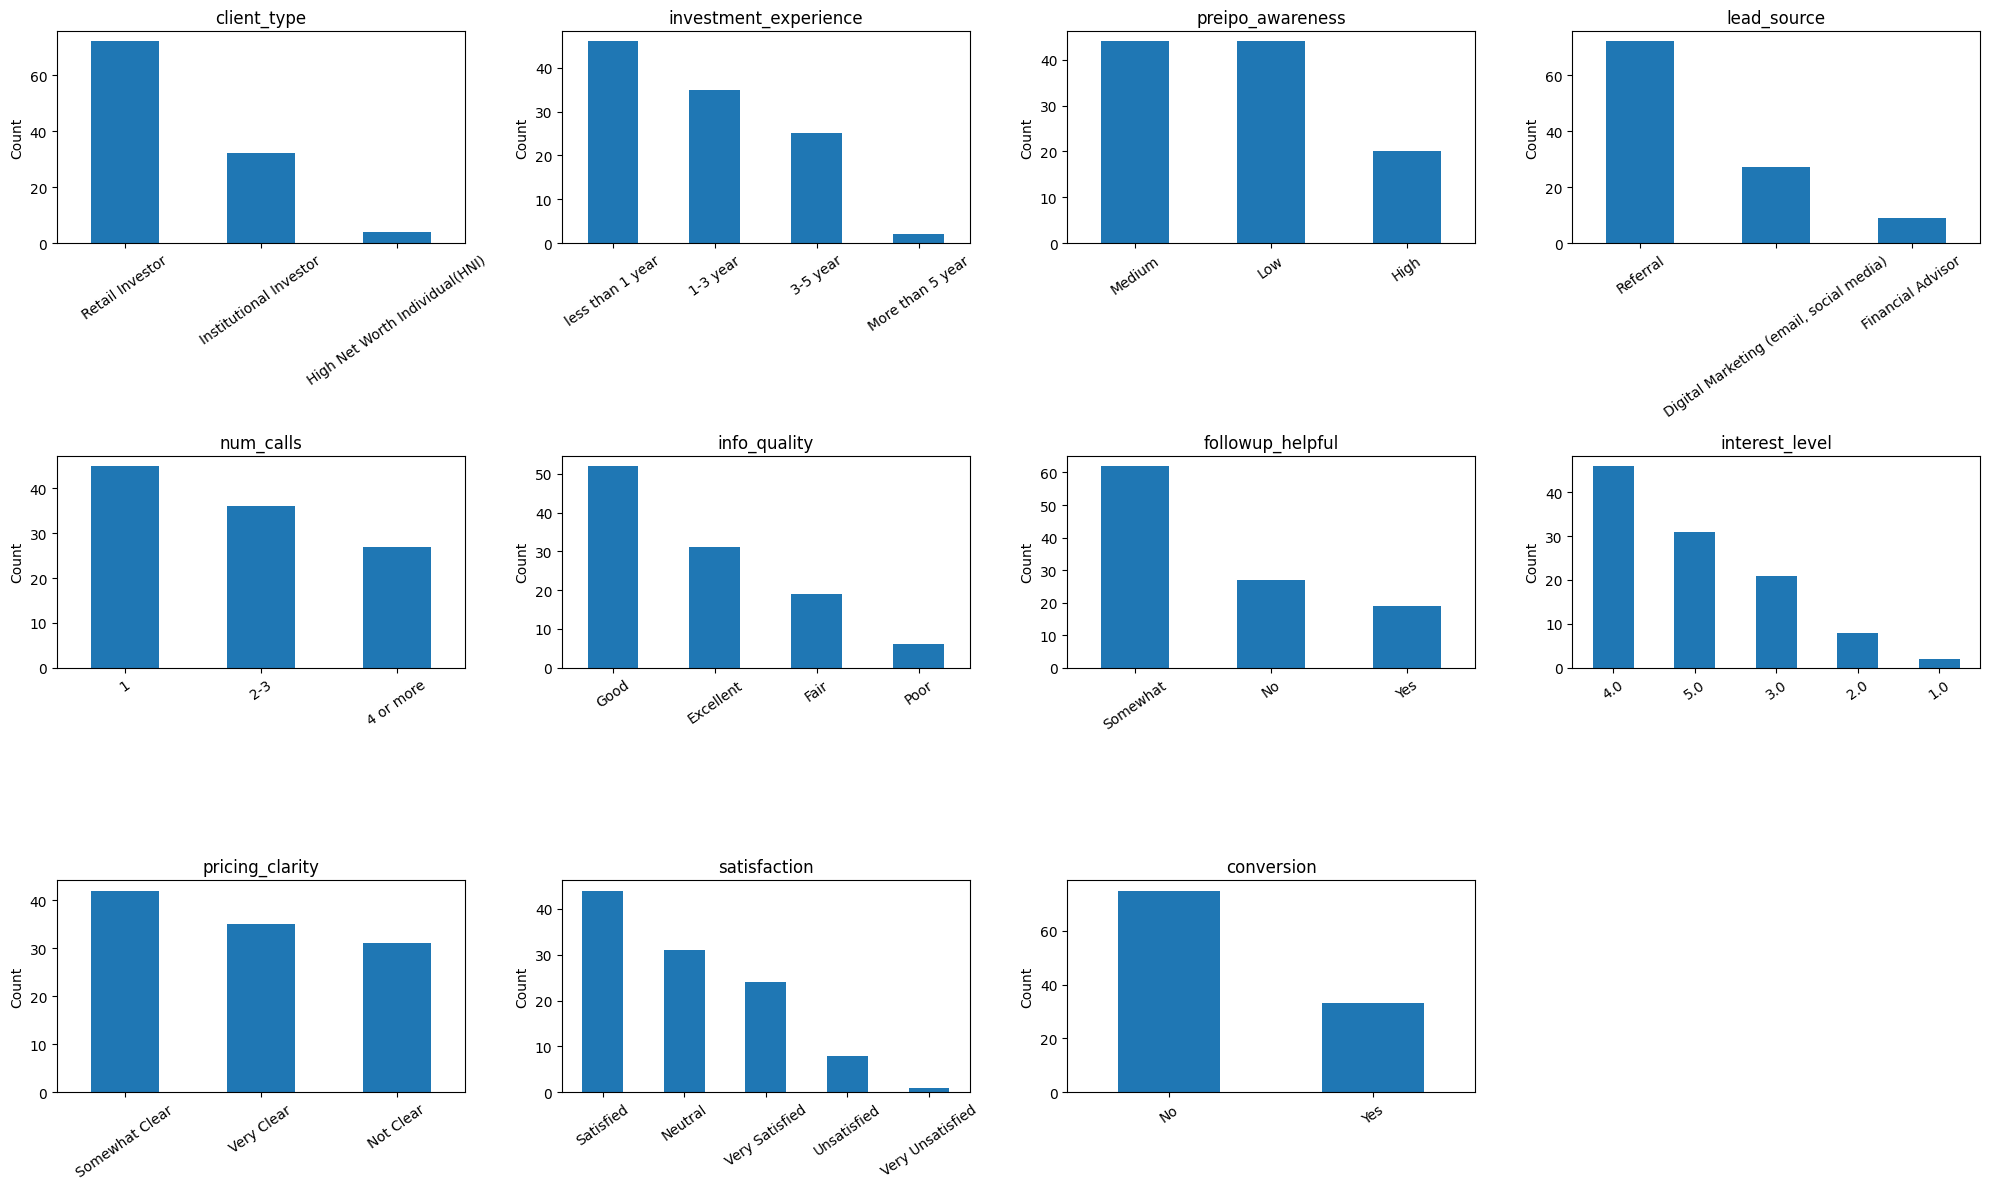

In [ ]:
import math
import matplotlib.pyplot as plt

cols = df.columns[2:]
n = len(cols)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    vc = df[col].value_counts()
    vc.plot.bar(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', labelrotation=35)


for ax in axes[n:]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()

In [ ]:
df['conversion_flag'] = df['conversion'].map({'Yes': 1, 'No': 0})

columns = ["client_type", "investment_experience", "num_calls"]
features = [col for col in columns if col not in ['conversion', 'conversion_flag']]

results = []
for feat in features:
    rates = df.groupby(feat)['conversion_flag'].mean() * 100
    results.append(pd.DataFrame({
        'feature': feat,
        'category': rates.index.astype(str),
        'conversion_rate (%)': rates.values.round(1)
    }))

conversion_rates_df = pd.concat(results, ignore_index=True)

conversion_rates_df

,feature,category,conversion_rate (%)
0,client_type,High Net Worth Individual(HNI),75.0
1,client_type,Institutional Investor,28.1
2,client_type,Retail Investor,29.2
3,investment_experience,1-3 year,28.6
4,investment_experience,3-5 year,32.0
5,investment_experience,More than 5 year,50.0
6,investment_experience,less than 1 year,30.4
7,num_calls,1,35.6
8,num_calls,2-3,25.0
9,num_calls,4 or more,29.6


In [ ]:
df['conversion_flag'] = df['conversion'].map({'Yes': 1, 'No': 0})

columns = df.columns[2:-2]

results = []
for col in columns:
    contingency = pd.crosstab(df[col], df['conversion_flag'])
    chi2, p, dof, exp = chi2_contingency(contingency)
    inference = 'Significant (p < 0.05)' if p < 0.05 else 'Not Significant (p >= 0.05)'
    results.append({
        'feature': col,
        'chi2_statistic': round(chi2, 3),
        'p_value': round(p, 3),
        'degrees_of_freedom': dof,
        'inference': inference
    })

results_df = pd.DataFrame(results)
results_df

,feature,chi2_statistic,p_value,degrees_of_freedom,inference
0,client_type,3.878,0.144,2,Not Significant (p >= 0.05)
1,investment_experience,0.446,0.931,3,Not Significant (p >= 0.05)
2,preipo_awareness,0.357,0.837,2,Not Significant (p >= 0.05)
3,lead_source,1.767,0.413,2,Not Significant (p >= 0.05)
4,num_calls,1.065,0.587,2,Not Significant (p >= 0.05)
5,info_quality,2.741,0.433,3,Not Significant (p >= 0.05)
6,followup_helpful,7.584,0.023,2,Significant (p < 0.05)
7,interest_level,6.516,0.164,4,Not Significant (p >= 0.05)
8,pricing_clarity,0.133,0.936,2,Not Significant (p >= 0.05)
9,satisfaction,4.843,0.304,4,Not Significant (p >= 0.05)


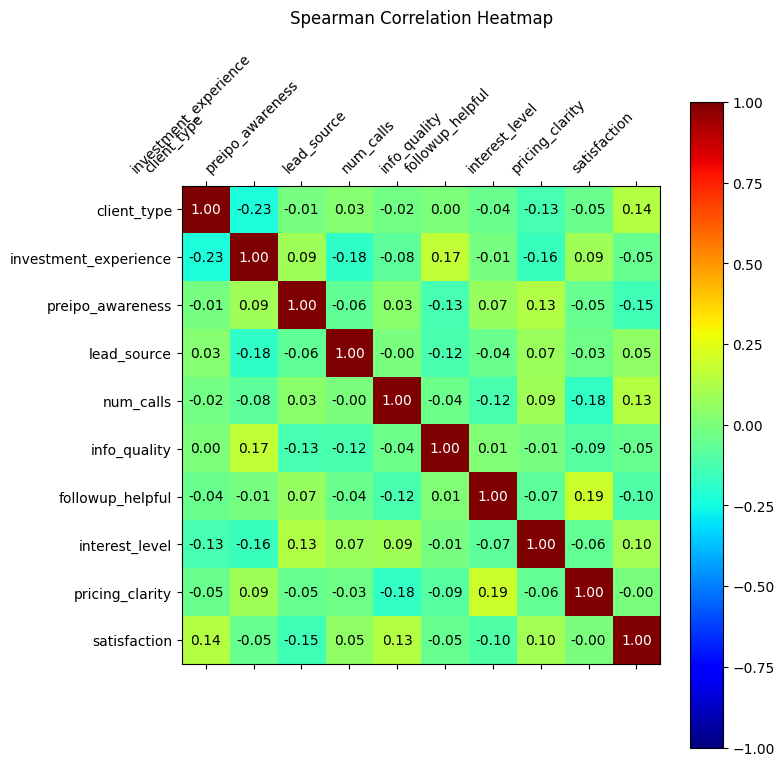

In [ ]:

cols = df.columns[2:-2]

df_enc = df[cols].apply(lambda x: x.astype('category').cat.codes)

spearman_corr = df_enc.corr(method='spearman')

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(spearman_corr, cmap='jet', vmin=-1, vmax=1, aspect='equal')
fig.colorbar(cax, ax=ax)

ax.set_xticks(range(len(cols)))
ax.set_yticks(range(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols)

for (i, j), val in np.ndenumerate(spearman_corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center',
            color='white' if abs(val) > 0.5 else 'black')

plt.title('Spearman Correlation Heatmap', pad=20)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df['conversion_flag'] = df['conversion'].map({'Yes': 1, 'No': 0})
df = df.drop("conversion", axis=1)

feature_cols = ['followup_helpful']
X = pd.get_dummies(df[feature_cols], drop_first=True)
y = df['conversion_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(class_weight='balanced',solver='liblinear', max_iter=1000, random_state=42)


In [ ]:
model.fit(X_train, y_train)
print("Training complete.")

Training complete.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No', 'Yes'], zero_division=1))

Accuracy: 77.27%

Classification Report:
              precision    recall  f1-score   support

          No       1.00      0.72      0.84        18
         Yes       0.44      1.00      0.62         4

    accuracy                           0.77        22
   macro avg       0.72      0.86      0.73        22
weighted avg       0.90      0.77      0.80        22



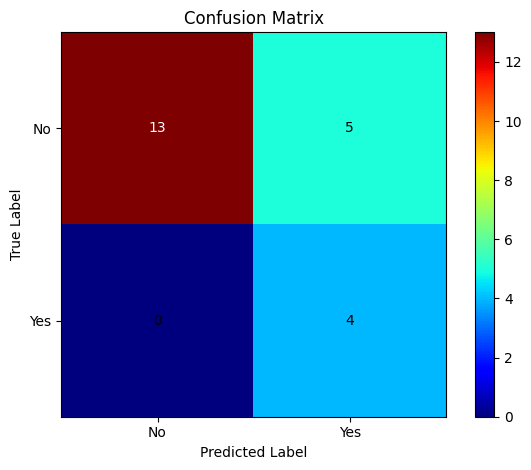

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap='jet')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=[0, 1],
    yticks=[0, 1],
    xticklabels=['No', 'Yes'],
    yticklabels=['No', 'Yes'],
    xlabel='Predicted Label',
    ylabel='True Label',
    title='Confusion Matrix'
)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha='center', va='center',
            color='white' if cm[i, j] > cm.max()/2 else 'black'
        )

plt.tight_layout()
plt.show()


In [ ]:
eqn = 'logit(conversion) = ' + ' + '.join(map(lambda tup: f"({tup[0]})*{tup[1]}", zip(model.coef_[0], model.feature_names_in_))) + ' + ' + f'({model.intercept_[0]})'
print(eqn)

logit(conversion) = (-0.42423015320534235)*followup_helpful_Somewhat + (0.4568664943915053)*followup_helpful_Yes + (0.11892884040836431)
